In [1]:
import pandas as pd
import numpy as np
from copy import deepcopy
import pickle
import cvxpy 
from cvxpy import *
from  sklearn.preprocessing import Normalizer, StandardScaler, MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
import csv
import sys

In [162]:
plt.rcParams.update({'font.size':18})
# plt.rcParams.update({'text.usetex' : True})
figDir = '/Users/aqib/Desktop/UCSB/research/BCCL/structured-dmd/NSBA_submission/figures/'
my_cmap = sns.diverging_palette(15, 221, s=99, sep=1, l=45, center='light',as_cmap=True)
# sns.choose_diverging_palette()
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

In [3]:
def snapshots_from_df(df):

    strains = ['wt','icar','phlf','nand']
    tps = ['5','18']
    temps = ['30','37']
    inducers = ['00','10','01','11']

    # create a dictionary where you specify strain, temp, and inducers as keys to grab the snapshot matrices
    snapshot_dict = {}
    for strain in strains: 
        snapshot_dict[strain] = {}
        for temp in temps: 
            snapshot_dict[strain][temp] = {}
            for inducer in inducers: 
                snapshot_dict[strain][temp][inducer] = {} # keys are to be Yf and Yp
                # get substring of colname that identifies the group (so everything except rep number)
                yp_colname = strain + '_' + inducer + temp + tps[0]
                # get list of indices that correspond to this group (in short, grabbing inds for all replicates)
                yp_col_inds = [ii for ii, this_col in enumerate(list(df.columns)) if yp_colname in this_col]
                snapshot_dict[strain][temp][inducer]['Yp'] = np.array(df.iloc[:,yp_col_inds])
                # do the same for the 18 hours timepoint i.e. Yf
                yf_colname = strain + '_' + inducer + temp + tps[1]
                yf_col_inds = [ii for ii, this_col in enumerate(list(df.columns)) if yf_colname in this_col]
                snapshot_dict[strain][temp][inducer]['Yf'] = np.array(df.iloc[:,yf_col_inds])
                
    return snapshot_dict

def get_unpaired_samples(df):
    # filter the samples that don't have a timepoint pair due to low sequencing depth
    unpaired_samples = []
    for sample in df.columns: 
        if '5' in sample:
            if sample.replace('5','18') not in df.columns:
                unpaired_samples.append(sample)
        elif '18' in sample: 
            if sample.replace('18','5') not in df.columns:
                unpaired_samples.append(sample)
    return unpaired_samples

In [4]:
def apply_normalizer(Yp,Yf):
    # normalize each datapoint to have unit norm
    transformer1 = Normalizer().fit(Yp.T)
    Yp_normed = transformer1.transform(Yp.T).T

    transformer2 = Normalizer().fit(Yf.T)
    Yf_normed = transformer2.transform(Yf.T).T
    return Yp_normed,Yf_normed

def apply_biased_StandardScaler(Yp,Yf):
    '''
    First each gene is given zero mean and unit variance (feature scaling rather than observation scaling).
    Then the entire dataset is shifted to be positive by adding the minimum value to each gene 
    '''
    # this function will only work for two-timepoint case. for more than two timepoints, i.e. where all but two timepoint is shared in Yp and Yf, need to reconsider
    Y = np.hstack((Yp,Yf))
    Ymean = np.mean(Y,axis=1)[:,np.newaxis]
    Ystd = np.std(Y,axis=1)[:,np.newaxis]
    Y_normed = (Y - Ymean)/Ystd
    Y_normed = Y_normed + (-np.nanmin(Y_normed))
    ndatapts = Yp.shape[1]
    Yp_normed = Y_normed[:,:ndatapts]
    Yf_normed = Y_normed[:,ndatapts:]
    return Yp_normed,Yf_normed

def apply_MinMaxScaler(Yp,Yf):
    '''
    Each gene will have range [0,1] (feature scaling rather than observation scaling).
    '''
    # this function will only work for two-timepoint case. for more than two timepoints, i.e. where all but two timepoint is shared in Yp and Yf, need to reconsider
    Y = np.hstack((Yp,Yf))
    Ymin = np.min(Y,axis=1)[:,np.newaxis]
    Ymax = np.max(Y,axis=1)[:,np.newaxis]
    Y_normed = (Y - Ymin)/(Ymax-Ymin)
    ndatapts = Yp.shape[1]
    Yp_normed = Y_normed[:,:ndatapts]
    Yf_normed = Y_normed[:,ndatapts:]
    return Yp_normed,Yf_normed

In [5]:
def get_ara_lac_genes(all_genes_filter):
    '''
    all_genes_filter: list of gene names in same order as df_tpm_filter
    '''
    lac_inds = [ii for ii,this_gene in enumerate(all_genes_filter) if 'lac' in this_gene]
    ara_inds = [ii for ii,this_gene in enumerate(all_genes_filter) if 'ara' in this_gene]
    lac_genes = [this_gene for ii,this_gene in enumerate(all_genes_filter) if 'lac' in this_gene]
    ara_genes = [this_gene for ii,this_gene in enumerate(all_genes_filter) if 'ara' in this_gene]
    my_genes = ara_genes + lac_genes
    my_inds = ara_inds + lac_inds
    return my_genes, my_inds

def get_rpoS_genes(all_genes_filter):

    rpoS_list = ['rpoS','acs','adhE','aldB','alkA','appY','cpxA','cpxR','dps','ftsQ','ftsA','ftsZ','katG',\
                'narZ','narY','narW','narV','nhaA','osmC','osmY','proP']
    my_inds = [ii for ii,this_gene in enumerate(all_genes_filter) if this_gene in rpoS_list]
    my_genes = [this_gene for ii,this_gene in enumerate(all_genes_filter) if this_gene in rpoS_list]
    
    return my_genes, my_inds

def get_DE_genes(res_dir_list,all_genes_filter,p_thresh=0.05,fc_thresh=2): 
    '''
    res_dir_list: list of directories for where to find DE results from DESeq2    

    '''
    res_list = []
    for res_dir in res_dir_list:  
        res_df = pd.read_csv(res_dir)
        # first filter by padj
        filter_p = res_df.loc[res_df.padj <  p_thresh]
        # next by FC
        res_filter_df  = filter_p.loc[np.abs(filter_p.log2FoldChange)>=\
                                                    np.log2(fc_thresh)]
        res_list.append(res_filter_df)

    # take the union of the genes remaining in each condition
    genes_DE = set()
    for res in res_list: 
        genes_DE = genes_DE.union(res.iloc[:,0]) # the first row contains gene names
    genes_DE = list(genes_DE)

    my_inds = [ii for ii,this_gene in enumerate(all_genes_filter) \
               for jj,DE_gene in enumerate(genes_DE) if  DE_gene == this_gene]
    my_genes = [all_genes_filter[ii] for ii in my_inds]

    return my_genes, my_inds

def get_acrR_genes(all_genes_filter):
    acrR_list = ['acrR','acrA','acrB']
    my_inds = [ii for ii,this_gene in enumerate(all_genes_filter) if this_gene in acrR_list]
    my_genes = [this_gene for ii,this_gene in enumerate(all_genes_filter) if this_gene in acrR_list]
    
    return my_genes, my_inds

def get_argR_genes(all_genes_filter):
    acrR_list = ['argR','argC','argB','argH','argD','argE','argF','argI','carA','carB']
    my_inds = [ii for ii,this_gene in enumerate(all_genes_filter) if this_gene in acrR_list]
    my_genes = [this_gene for ii,this_gene in enumerate(all_genes_filter) if this_gene in acrR_list]
    
    return my_genes, my_inds
    

In [6]:
def calc_Koopman(Yf,Yp,flag=1,lambda_val=0.0,noise_scaler=1,lambda_val_1=0.0,verbose=True):
    ngenes = Yf.shape[0]
    ndatapts = Yf.shape[1]
    solver_instance = cvxpy.SCS
    
    if flag == 1: # least-squares solution
        Yp_inv = np.linalg.pinv(Yp)
        K = np.dot(Yf,Yp_inv)
        # TO DO: Add SVD based DMD for modal decompostion (modes can be insightful)
        
    if flag == 2: # LASSO optimization 
        print('L1 Regularization')
        operator = Variable(shape=(ngenes,ngenes))
        
        print("[INFO]: CVXPY Koopman operator variable: " + repr(operator.shape))
        print("[INFO]: Shape of Yf and Yp: " + repr(Yf.shape) + ', ' + repr(Yp.shape) )
        
        if type(lambda_val) == float:
            reg_term = lambda_val * cvxpy.norm(operator,p=1)
        else: 
            Unoise = np.tile(lambda_val,ndatapts)
            reg_term = cvxpy.norm(cvxpy.matmul(operator + np.eye(ngenes),noise_scaler*Unoise),p=1)
        norm2_fit_term = cvxpy.norm(Yf - cvxpy.matmul(operator,Yp),p=2)
        
        objective = Minimize(norm2_fit_term + reg_term)
        constraints = []
        prob = Problem(objective,constraints)
        result = prob.solve(verbose=verbose,solver=solver_instance,max_iters=int(1e6))
        K = operator.value
        
        print("[INFO]: CVXPY problem status: " + prob.status)
        
    if flag == 3: # robust optimization approach
        print("L2,2 Regularization")
        
        operator = Variable(shape=(ngenes,ngenes)) # Koopman matrix  K
        
        print("[INFO]: CVXPY Koopman operator variable: " + repr(operator.shape))
        print("[INFO]: Shape of Yf and Yp: " + repr(Yf.shape) + ', ' + repr(Yp.shape) )
        
        if type(lambda_val) == float:
            reg_term = lambda_val * cvxpy.norm(operator,p='fro')
        else: 
            Unoise = np.tile(lambda_val,ndatapts)
            reg_term = cvxpy.norm(cvxpy.matmul(operator + np.eye(ngenes),noise_scaler*Unoise),p='fro') # in 2019, we had assumed that 
        norm2_fit_term = cvxpy.norm(Yf - cvxpy.matmul(operator,Yp),p=2)
        
        objective = Minimize(norm2_fit_term + reg_term)
        constraints = []
        prob = Problem(objective,constraints)
        result = prob.solve(verbose=verbose,solver=solver_instance,max_iters=int(1e6))
        K = operator.value
        
        print("[INFO]: CVXPY problem status: " + prob.status)
    
    if flag == 4: 
        print('L1 and L2,2 Regularization')
        operator = Variable(shape=(ngenes,ngenes)) # Koopman matrix  K
        
        print("[INFO]: CVXPY Koopman operator variable: " + repr(operator.shape))
        print("[INFO]: Shape of Yf and Yp: " + repr(Yf.shape) + ', ' + repr(Yp.shape) )
        
        Unoise = np.tile(lambda_val,ndatapts)
        regF_term = cvxpy.norm(cvxpy.matmul(operator + np.eye(ngenes),noise_scaler*Unoise),p='fro') 
        reg1_term = lambda_val_1 * cvxpy.norm(operator,p=1)

        norm2_fit_term = cvxpy.norm(Yf - cvxpy.matmul(operator,Yp),p=2)
        
        objective = Minimize(norm2_fit_term + regF_term + reg1_term)
        constraints = []
        prob = Problem(objective,constraints)
        result = prob.solve(verbose=verbose,solver=solver_instance,max_iters=20000)
        K = operator.value
        
        print("[INFO]: CVXPY problem status: " + prob.status)
        
    if flag == 5: # robust optimization approach
        print("L2,2 (robust) Regularization but exactly as theory suggests, so only noise from Yp should be used")
        
        operator = Variable(shape=(ngenes,ngenes)) # Koopman matrix  K
        
        print("[INFO]: CVXPY Koopman operator variable: " + repr(operator.shape))
        print("[INFO]: Shape of Yf and Yp: " + repr(Yf.shape) + ', ' + repr(Yp.shape) )
        
        if type(lambda_val) == float:
            reg_term = lambda_val * cvxpy.norm(operator,p='fro')
        else: 
            Unoise = np.tile(lambda_val,ndatapts)
            reg_term = cvxpy.norm(cvxpy.matmul(operator + np.eye(ngenes),noise_scaler*Unoise),p='fro') 
        norm2_fit_term = cvxpy.norm(Yf - cvxpy.matmul(operator,Yp),p=2)
        
        objective = Minimize(norm2_fit_term + reg_term)
        constraints = []
        prob = Problem(objective,constraints)
        result = prob.solve(verbose=verbose,solver=solver_instance,max_iters=int(1e6))
        K = operator.value
        
        print("[INFO]: CVXPY problem status: " + prob.status)

                
    print('MSE =  ' + '{:0.3e}'.format(mean_squared_error(Yf,K@Yp))) 
    print('\n','\n')

    return K

def calc_input_Koopman(LHS,Up,flag=1,lambda_val=0.0,noise_scaler=1,verbose=True):
    ''' From Yf=AYp+BUp or Yf-AYp=BUp (A known) or Yf-(AYp + B_1U1 + ... )=B_JUJ (B_1 to B_J-1 known), we see 
        that the optimization can always be written as ||loss_lhs - operator*Up||_2 + ||G(operator)||_F.
    '''
    ngenes = LHS.shape[0]
    ndatapts = LHS.shape[1]
    ninputs = Up.shape[0]

    if flag == 1: # least-squares solution
        Up_inv = np.linalg.pinv(Up)
        Ki = np.dot(LHS,Up_inv)
        print('The mean squared error is: ' + '{:0.3e}'.format(np.linalg.norm(LHS - Ki@Up)**2 / ndatapts)) 
        # TO DO: Add SVD based DMD for modal decompostion (modes can be insightful)
        
    if flag == 2: # robust optimization approach
        solver_instance = cvxpy.SCS
        operator = Variable(shape=(ngenes,ninputs)) # Koopman matrix  K
        
        print("[INFO]: CVXPY Koopman operator variable: " + repr(operator.shape))
        
        if type(lambda_val) == float:
            reg_term = lambda_val * cvxpy.norm(operator,p=1) 
        else:
            Unoise = np.tile(lambda_val,ndatapts)
            reg_term = cvxpy.norm(cvxpy.matmul(operator,noise_scaler*Unoise),p='fro') # where exactly does this term come from? 

        norm2_fit_term = cvxpy.norm(LHS - cvxpy.matmul(operator,Up),p=2) 
        objective = Minimize(norm2_fit_term + reg_term)
        constraints = []
        prob = Problem(objective,constraints)
        result = prob.solve(verbose=verbose,solver=solver_instance,max_iters=20000)
        Ki = operator.value

        print("[INFO]: CVXPY problem status: " + prob.status)
        print('MSE =  ' + '{:0.3e}'.format(mean_squared_error(LHS,Ki@Up))) 
        print('\n','\n')

    return Ki

def koopman_heatmap(thisK,figsize,xlabels,ylabels,shrink,savefig=False,savedir=''):
    fig = plt.figure(figsize=figsize)
    hm = sns.heatmap(thisK,linewidths=0.0,cmap=my_cmap,xticklabels=xlabels,yticklabels=ylabels,
                linecolor='white',square=True,annot=False,annot_kws={"size":11},fmt='2.1f',
                     cbar_kws={'shrink':shrink},center=0)
    if thisK.shape[1] == 1: 
        plt.xticks(fontsize=20,rotation='horizontal');
    else: 
        plt.xticks(fontsize=20,rotation='vertical');
    plt.yticks(fontsize=18,rotation='horizontal')
    plt.axhline(y=0, color='k',linewidth=3)
    plt.axhline(y=thisK.shape[0], color='k',linewidth=3)
    plt.axvline(x=0, color='k',linewidth=3)
    plt.axvline(x=thisK.shape[1], color='k',linewidth=3)
    cax = fig.axes[-1]
    cax.set_frame_on(True)
    for spine in cax.spines.values():
        spine.set(visible=True, lw=1, edgecolor='k')
    plt.tight_layout()
    if savefig:
        plt.savefig(savedir,dpi=300,bbox_inches='tight',transparent=True)
    plt.show()

In [21]:
# Load TPM or GeTMM dataframe (results are identical, implying GeTMM normalization is unnecessary for our dataset)
df_tpm_filter = pd.read_csv('data/TPM_matrix_NAND.csv') # suffix is 'filter' because very low count genes have already been removed
# get list of samples that are to be removed because they don't have a timepoint pair, 
# i.e. a col in Xp does not have corresponding col in Xf or vice versa
unpaired_samples = get_unpaired_samples(df_tpm_filter)
# get gene names
all_genes_filter =  df_tpm_filter['gene'] 
# remove 'gene' col from df
df_tpm_filter = df_tpm_filter.iloc[:,1:]
# drop the unpaired samples
df_tpm_filter = df_tpm_filter.drop(columns=unpaired_samples).reset_index(drop=True)

# path to deseq results for gene downselection 
res_dir_list = ['data/condition_nand00375_vs_wt00375_results.csv',\
                'data/condition_nand003718_vs_wt003718_results.csv']

# get all snapshots keyed in the following way: 
# [strain][temperature][inducer][snapshots]
snapshot_dict = snapshots_from_df(df_tpm_filter)

# the strains are ['wt','icar','phlf','nand']
# the temperatures are ['30','37']
# the inducers are ['00','10','01','11'] ([arabinose,iptg])
# the snapshots are ['Yp','Yf']

# get circuit gene names and indices
circuit_inds = list(range(13)) # circuit genes are in first 13 rows of df
circuit_genes = all_genes_filter[:13]

# select genes for modeling
ara_lac = 0 # 13 ara and lac genes
rpoS_genes = 0 # rpoS and known regulated genes
acrR_genes = 0 # acrR and known regulated genes
argR_genes = 0 # argR and known regulated genes
# see: https://www.weizmann.ac.il/mcb/UriAlon/e-coli-transcription-network#:~:text=E.-,coli%20transcription%20network,in%20cells%20orchestrate%20gene%20expression.&text=Each%20network%20motif%20has%20a,responses%20to%20fluctuating%20external%20signals.
de_only = 1 # only differentially expressed genes

# get host gene names and indices
if ara_lac:
    p_thresh, fc_thresh = 'n/a', 'n/a'
    my_genes,  my_inds  = get_ara_lac_genes(all_genes_filter) # only ara and lac genes, want to create more smaller networks like this:
    selected_genes = 'ara_lac'
elif rpoS_genes: 
    p_thesh, fc_thresh = 'n/a', 'n/a'
    my_genes, my_inds = get_rpoS_genes(all_genes_filter)
    selected_genes = 'rpoS_genes'
elif acrR_genes: 
    p_thesh, fc_thresh = 'n/a', 'n/a'
    my_genes, my_inds = get_acrR_genes(all_genes_filter)
    selected_genes = 'acrR_genes'
elif argR_genes: 
    p_thesh, fc_thresh = 'n/a', 'n/a'
    my_genes, my_inds = get_argR_genes(all_genes_filter)
    selected_genes = 'argR_genes'
elif de_only: 
    p_thresh, fc_thresh = 0.05, 2
    my_genes, my_inds = get_DE_genes(res_dir_list,all_genes_filter,p_thresh=p_thresh,fc_thresh=fc_thresh)
    selected_genes = 'de_only'
print(len(my_genes), 'genes kept for modeling.')

    
TEMP = '37'
NOISE_SCALER = 1 # scale the bounded uncertainty set dU
VERBOSE = True # print optimization log from the scs solver
# save state-space model
doSave = False
fn = 'x8_NAND' # name to save pickle file as, will also be used as id for run

# ensure unique filename/id is being used for the run
if doSave: 
    prev_ids = pd.read_csv('data/run_log.csv')['id']
    if fn in list(prev_ids):
        sys.exit("The id (fn) being used already exists in run_log.csv. Provide a unique name and retry.")
        

695 genes kept for modeling.


#### Structured learning sequence:
- 0) Learn host dynamics from wild type 
- 1) Learn single inducer impact on host (arabinose and iptg separate)
- 2) Learn control matrix that accounts for PhlF gate + arabinose dynamics
- 3) Learn control matrix that accounts for IcaR gate + IPTG dynamics
- 4) Learn control matrix that accounts for NAND circuit + arabinose + iptg + phlf + nand

In [55]:
################# Wild type dynamics ###################################
Yp = snapshot_dict['wt'][TEMP]['11']['Yp']
Yf = snapshot_dict['wt'][TEMP]['11']['Yf']
# normalize each snapshot to have unit norm, a dynamics preserving transformation
Yp_normed, Yf_normed = apply_normalizer(Yp,Yf)
# Yp_normed, Yf_normed = apply_biased_StandardScaler(Yp,Yf)
# Yp_normed, Yf_normed = apply_MinMaxScaler(Yp,Yf)
# Yp_normed, Yf_normed = Yp, Yf
Yp_normed, Yf_normed = Yp_normed[my_inds], Yf_normed[my_inds]
# Yp_normed, Yf_normed = np.vstack((0.0001*np.ones((1,Yp_normed.shape[1])),Yp_normed)), np.vstack((0.0001*np.ones((1,Yf_normed.shape[1])),Yf_normed))
# compute the intrareplicate noise for regularizing K as motivated by Robust DMD
lambda_val_vec_p = np.std(Yp_normed,axis=1)[:,np.newaxis]
lambda_val_vec_f = np.std(Yf_normed,axis=1)[:,np.newaxis]
lambda_val_vec = np.std(np.hstack((lambda_val_vec_p,lambda_val_vec_f)),axis=1)[:,np.newaxis]
# lambda_val_vec = lambda_val_vec_p
# K = calc_Koopman(Yf_normed,Yp_normed,flag=2,lambda_val=lambda_val_vec,\
#     noise_scaler=NOISE_SCALER,verbose=VERBOSE)
K = calc_Koopman(Yf_normed,Yp_normed,flag=3,lambda_val=lambda_val_vec,\
    noise_scaler=NOISE_SCALER,verbose=VERBOSE)
# K = calc_Koopman(Yf_normed,Yp_normed,flag=4,lambda_val=lambda_val_vec,\
#       noise_scaler=NOISE_SCALER,lambda_val_1=0.1,verbose=VERBOSE)

L2,2 Regularization
[INFO]: CVXPY Koopman operator variable: (13, 13)
[INFO]: Shape of Yf and Yp: (13, 3), (13, 3)
----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 1031
eps = 1.00e-04, alpha = 1.50, max_iters = 1000000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 171, constraints m = 176
Cones:	soc vars: 40, soc blks: 1
	sd vars: 136, sd blks: 1
Setup time: 1.51e-03s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 2.23e-01  7.48e-01  5.56e-02 -5.78e-02  1.04e-03  5.79e-17  1.60e-03 
    14| 1.21e-11  1.24e-11  1.86e-12 -9.97e-13  8.

In [366]:
################# WT + arabinose dynamics ###################################
Yp = snapshot_dict['wt'][TEMP]['10']['Yp']
Yf = snapshot_dict['wt'][TEMP]['10']['Yf']
# normalize each snapshot to have unit norm, a dynamics preserving transformation
Yp_normed, Yf_normed = apply_normalizer(Yp,Yf)
Yp_normed, Yf_normed = Yp_normed[my_inds], Yf_normed[my_inds]
# treat arabinose as a step input to the system 
Uara = (Yp_normed.max() - Yf_normed.min())/2 * np.ones((1,Yp_normed.shape[1]))
# the scaling coefficient is to have mag of step be on same scale as the data
# compute the intrareplicate noise for regularizing K as motivated by Robust DMD
lambda_val_vec = np.std(Uara,axis=1)[:,np.newaxis]
# form the LHS of the optimization problem
LHS = Yf_normed  - K@Yp_normed
Kara = calc_input_Koopman(LHS,Uara,flag=2,lambda_val=lambda_val_vec,\
    noise_scaler=NOISE_SCALER,verbose=VERBOSE)

################# WT + IPTG dynamics ###################################
Yp = snapshot_dict['wt'][TEMP]['01']['Yp']
Yf = snapshot_dict['wt'][TEMP]['01']['Yf']
# normalize each snapshot to have unit norm, a dynamics preserving transformation
Yp_normed, Yf_normed = apply_normalizer(Yp,Yf)
Yp_normed, Yf_normed = Yp_normed[my_inds], Yf_normed[my_inds]
# treat arabinose as a step input to the system 
Uiptg = (Yp_normed.max() - Yf_normed.min())/2 * np.ones((1,Yp_normed.shape[1]))
# the scaling coefficient is to have mag of step be on same scale as the data
# compute the intrareplicate noise for regularizing K as motivated by Robust DMD
lambda_val_vec = np.std(Uiptg,axis=1)[:,np.newaxis]
# form the LHS of the optimization problem
LHS = Yf_normed  - K@Yp_normed
Kiptg = calc_input_Koopman(LHS,Uiptg,flag=2,lambda_val=lambda_val_vec,\
    noise_scaler=NOISE_SCALER,verbose=VERBOSE)

################# PhlF Gate + arabinose dynamics ###################################
Yp = snapshot_dict['phlf'][TEMP]['01']['Yp']
Yf = snapshot_dict['phlf'][TEMP]['01']['Yf']
# normalize each snapshot to have unit norm, a dynamics preserving transformation
Yp_normed, Yf_normed = apply_normalizer(Yp,Yf)
Uphlf_p, Uphlf_f = Yp_normed[circuit_inds], Yf_normed[circuit_inds]
Yp_normed, Yf_normed = Yp_normed[my_inds], Yf_normed[my_inds]
# compute the intrareplicate noise for regularizing K as motivated by Robust DMD
lambda_val_vec_p = np.std(Uphlf_p,axis=1)[:,np.newaxis]
lambda_val_vec_f = np.std(Uphlf_f,axis=1)[:,np.newaxis]
lambda_val_vec = np.std(np.hstack((lambda_val_vec_p,lambda_val_vec_f)),axis=1)[:,np.newaxis]
# if number of samples in Yp/Yf do not match the number of  samples in the 
# previously used step inputs, simply downselect the step input as we do here
# form the LHS of the optimization problem
LHS = Yf_normed  - K@Yp_normed - Kara@Uara[:,:-1]
Kphlf = calc_input_Koopman(LHS,Uphlf_p,flag=2,lambda_val=lambda_val_vec,\
    noise_scaler=NOISE_SCALER,verbose=VERBOSE)

################# IcaR Gate + IPTG dynamics ###################################
Yp = snapshot_dict['icar'][TEMP]['01']['Yp']
Yf = snapshot_dict['icar'][TEMP]['01']['Yf']
# normalize each snapshot to have unit norm, a dynamics preserving transformation
Yp_normed, Yf_normed = apply_normalizer(Yp,Yf)
Uicar_p, Uicar_f = Yp_normed[circuit_inds], Yf_normed[circuit_inds]
Yp_normed, Yf_normed = Yp_normed[my_inds], Yf_normed[my_inds]
# compute the intrareplicate noise for regularizing K as motivated by Robust DMD
lambda_val_vec_p = np.std(Uicar_p,axis=1)[:,np.newaxis]
lambda_val_vec_f = np.std(Uicar_f,axis=1)[:,np.newaxis]
lambda_val_vec = np.std(np.hstack((lambda_val_vec_p,lambda_val_vec_f)),axis=1)[:,np.newaxis]
# if number of samples in Yp/Yf do not match the number of  samples in the 
# previously used step inputs, simply downselect the step input as we do here
# this will only be an issue with the manually defined step inputs
# form the LHS of the optimization problem
if TEMP == '37':
    LHS = Yf_normed  - K@Yp_normed - Kiptg@Uiptg[:,:-1]
elif TEMP == '30':
    LHS = Yf_normed  - K@Yp_normed - Kiptg@np.hstack((Uiptg,Uiptg[:,0:1]))
Kicar = calc_input_Koopman(LHS,Uicar_p,flag=2,lambda_val=lambda_val_vec,\
    noise_scaler=NOISE_SCALER,verbose=VERBOSE)

########## NAND Circuit + arabinose + IPTG + Phlf Gate + Icar Gate dynamics ###################################
Yp = snapshot_dict['nand'][TEMP]['11']['Yp']
Yf = snapshot_dict['nand'][TEMP]['11']['Yf']
# normalize each snapshot to have unit norm, a dynamics preserving transformation
Yp_normed, Yf_normed = apply_normalizer(Yp,Yf)
Unand_p, Unand_f = Yp_normed[circuit_inds], Yf_normed[circuit_inds]
Yp_normed, Yf_normed = Yp_normed[my_inds], Yf_normed[my_inds]
# compute the intrareplicate noise for regularizing K as motivated by Robust DMD
lambda_val_vec_p = np.std(Unand_p,axis=1)[:,np.newaxis]
lambda_val_vec_f = np.std(Unand_f,axis=1)[:,np.newaxis]
lambda_val_vec = np.std(np.hstack((lambda_val_vec_p,lambda_val_vec_f)),axis=1)[:,np.newaxis]
# form the LHS of the optimization problem
if TEMP == '37':
    LHS = Yf_normed  - K@Yp_normed - Kiptg@Uiptg - Kara@Uara  - \
        Kphlf@Unand_p - Kicar@Unand_p
elif TEMP == '30':
    LHS = Yf_normed  - K@Yp_normed - Kiptg@Uiptg \
        - Kara@Uara[:,:-1]  - Kphlf@Unand_p - Kicar@Unand_p
Knand = calc_input_Koopman(LHS,Unand_p,flag=2,lambda_val=lambda_val_vec,\
    noise_scaler=NOISE_SCALER,verbose=VERBOSE)

[INFO]: CVXPY Koopman operator variable: (695, 1)
----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 3480
eps = 1.00e-04, alpha = 1.50, max_iters = 20000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 697, constraints m = 247431
Cones:	soc vars: 2781, soc blks: 1
	sd vars: 244650, sd blks: 1
Setup time: 4.10e-02s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 7.06e-01  8.83e+01  9.76e-01 -1.39e-02  4.11e+01  1.25e-14  1.07e-01 
    67| 6.80e-11  1.97e-08  1.06e-08  2.57e-01  2.57e-01  4.74e-15  4.23e+00 
-------------------------------

   100| 1.76e-02  4.14e-01  6.11e-02  6.51e-02 -0.00e+00  5.69e-16  1.11e+01 
   200| 2.88e-03  1.51e-01  6.10e-02  6.93e-04  6.57e-02  8.73e-16  2.78e+01 
   300| 2.57e-04  4.14e-01  4.46e-04  4.46e-04 -0.00e+00  2.01e-15  3.93e+01 
   400| 2.35e-04  4.14e-01  7.01e-04  7.02e-04 -0.00e+00  7.16e-16  5.15e+01 
   500| 4.30e-04  3.91e-01  2.03e-02  6.27e-04 -2.01e-02  4.13e-15  6.32e+01 
   600| 7.40e-10  8.31e-08  2.19e-08 -9.31e-14  2.19e-08  1.30e-15  8.02e+01 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 8.02e+01s
	Lin-sys: nnz in L factor: 314848, avg solve time: 1.35e-03s
	Cones: avg projection time: 1.08e-01s
	Acceleration: avg step time: 1.91e-02s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 1.3849e-11, dist(y, K*) = 1.4365e-09, s'y/|s||y| = 3.6686e-03
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 7.3980e-10
dual res:   |A'y + c|_2 / (1 + |c|_2) = 8.3112e-0

   100| 2.20e-02  4.56e+01  2.49e-02 -1.26e-03 -2.68e-02  4.02e-16  8.92e+00 
   200| 2.37e-04  4.12e-01  1.13e-03  6.13e-04 -5.23e-04  1.29e-15  1.95e+01 
   232| 6.28e-11  2.42e-09  1.46e-10 -7.82e-13 -1.47e-10  1.37e-15  2.97e+01 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 2.97e+01s
	Lin-sys: nnz in L factor: 315543, avg solve time: 1.34e-03s
	Cones: avg projection time: 1.02e-01s
	Acceleration: avg step time: 1.90e-02s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 1.0059e-11, dist(y, K*) = 2.4296e-09, s'y/|s||y| = -7.2703e-03
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 6.2847e-11
dual res:   |A'y + c|_2 / (1 + |c|_2) = 2.4233e-09
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 1.4578e-10
----------------------------------------------------------------------------
c'x = -0.0000, -b'y = -0.0000
[INFO]: CVXPY problem status: optimal
MSE =  9.935e-27

 

[INFO]

In [ ]:
if doSave: 
    pickle.dump([K,Kara,Kiptg,Kphlf,Kicar,Knand,my_genes,my_inds],open('data/'+fn+'.pkl','wb'))
    df = pd.DataFrame({'id':[fn],'n_genes':[len(my_genes)],'padj_thresh':[p_thresh],'fc_thresh':[fc_thresh],\
                        'selected_genes':selected_genes,'noise_scaler':NOISE_SCALER,'temp':TEMP})
    # before writing to run_log, need to start newline
    with open('data/run_log.csv', 'a') as f:
        f.write('\n')
    df.to_csv('data/run_log.csv', mode='a', index=False, header=False)

In [180]:
Yp_mean = np.mean(Yp_normed,axis=1)[:,np.newaxis]
Yp_mean_mat = np.tile(Yp_mean,Yp_mean.shape[0]) 

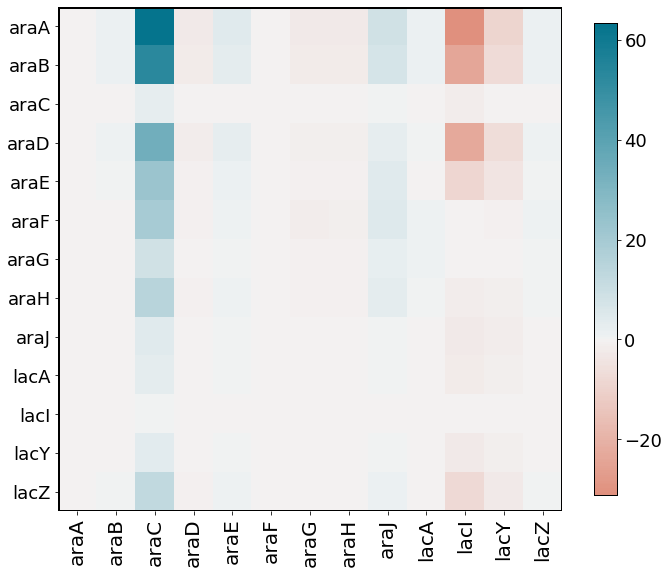

1.0886265112948346e-24 1.0


In [56]:
######## Visualize host-interactions as heatmap ############
SAVEFIG = False
SAVEDIR = figDir+'fig1/Khost1137_ara-lac.pdf'
FIGSIZE = (10,10)
CBARSHRINK = 0.7
ik,fk = 0, K.shape[1]
# XLAB, YLAB = ['bias'] + my_genes, ['bias'] + my_genes
# ik,fk = 0, 30
if ik == 0 and fk == K.shape[1]:
    XLAB, YLAB = [], []
else: 
    XLAB,YLAB = my_genes[ik:fk],my_genes[ik:fk]    
if len(my_genes) < 30: 
        XLAB, YLAB = my_genes, my_genes

koopman_heatmap(K[ik:fk,ik:fk],FIGSIZE,XLAB,YLAB,CBARSHRINK,savefig=SAVEFIG,savedir=SAVEDIR)
print(mean_squared_error(Yf_normed,K@Yp_normed), r2_score(Yf_normed,K@Yp_normed))

# koopman_heatmap((K * Yp_mean_mat.T)[ik:fk,ik:fk],FIGSIZE,XLAB,YLAB,CBARSHRINK,savefig=SAVEFIG,savedir=SAVEDIR)

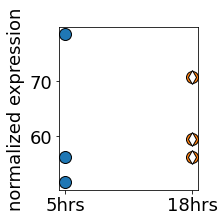

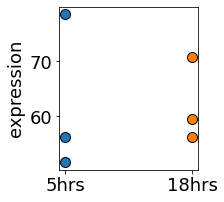

In [325]:
kk = my_genes.index('acrR')
plt.figure(figsize=(2.5,3))
plt.plot(['5hrs']*Yp_normed.shape[1],Yp_normed[kk],'o',ms=12,mec='k')
plt.plot(['18hrs']*Yf_normed.shape[1],Yf_normed[kk],'o',ms=12,mec='k')
plt.plot(['18hrs']*Yf_normed.shape[1],(K@Yp_normed)[kk],'d',c='white',ms=10,mec='k',alpha=1)
plt.ylabel('normalized expression')
plt.show()
plt.figure(figsize=(2.5,3))
plt.plot(['5hrs']*Yp.shape[1],Yp[my_inds][kk],'o',ms=10,mec='k')
plt.plot(['18hrs']*Yf.shape[1],Yf[my_inds][kk],'o',ms=10,mec='k')
plt.ylabel('expression')
plt.show()

In [272]:
impacted_genes = np.linalg.norm(K,axis=1,ord=2)

<AxesSubplot:>

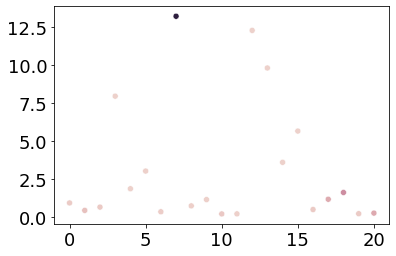

In [273]:
sns.scatterplot(x=list(range(len(impacted_genes))),y=impacted_genes,
                hue=(np.hstack((Yp_normed,Yf_normed)).mean(axis=1)),legend=False)

In [274]:
affector_genes = np.linalg.norm(K,axis=0,ord=2)

<AxesSubplot:>

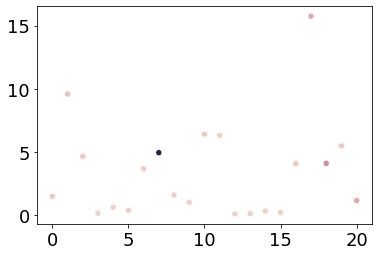

In [275]:
sns.scatterplot(x=list(range(len(affector_genes))),y=affector_genes,
                hue=(np.hstack((Yp_normed,Yf_normed)).mean(axis=1)),legend=False)

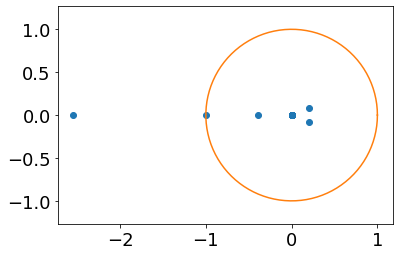

In [276]:
eigvals = np.linalg.eigvals(K)
plt.plot(np.real(eigvals),np.imag(eigvals),'o')
theta = np.linspace(0,2*np.pi,100)
plt.plot(np.cos(theta),np.sin(theta))
plt.axis('equal')
plt.show()

In [277]:
np.abs(eigvals)

array([2.54808604e+00, 1.00000000e+00, 3.90815600e-01, 2.21620032e-01,
       2.21620032e-01, 1.64753091e-14, 1.63566673e-15, 1.63566673e-15,
       1.50562614e-15, 1.50562614e-15, 1.51836629e-15, 1.07711884e-15,
       1.07711884e-15, 1.18909197e-15, 8.28234250e-16, 8.28234250e-16,
       8.40476842e-16, 8.40476842e-16, 5.45760451e-16, 1.44920810e-16,
       1.44920810e-16])

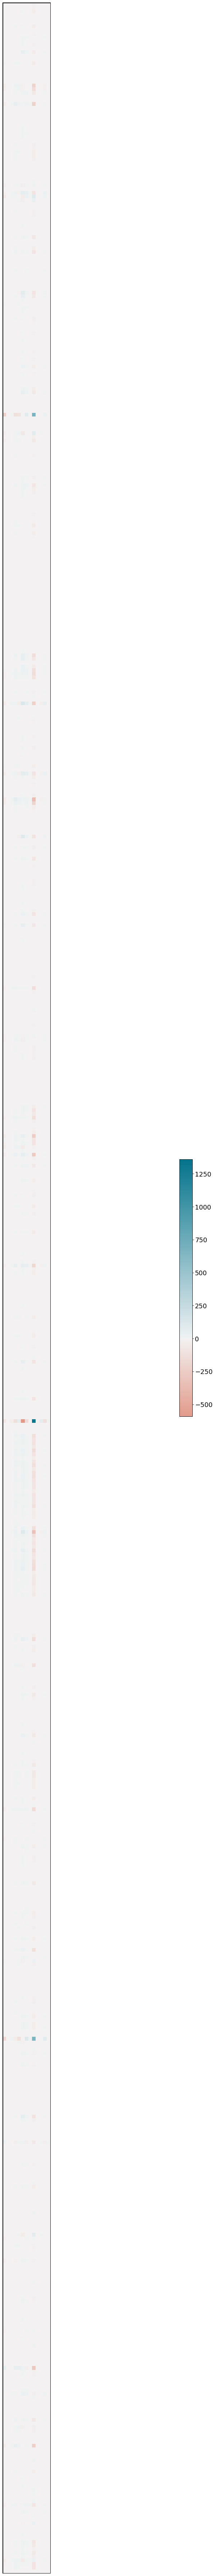

In [368]:
######## Visualize circuit impact on all host genes ############
SAVEFIG = False
SAVEDIR = figDir+'fig1/Knand.pdf'
FIGSIZE = (100,100)
CBARSHRINK = 0.1
ik,fk = 0, K.shape[1]
# XLAB, YLAB = ['bias'] + my_genes, ['bias'] + my_genes
# ik,fk = 0, 30
if ik == 0 and fk == K.shape[1]:
    XLAB, YLAB = [], []
else: 
    XLAB,YLAB = my_genes[ik:fk],my_genes[ik:fk]    
if len(my_genes) < 30: 
    XLAB, YLAB = my_genes, my_genes

koopman_heatmap(Knand,FIGSIZE,XLAB,YLAB,CBARSHRINK,savefig=SAVEFIG,savedir=SAVEDIR)
# print(mean_squared_error(Yf_normed,K@Yp_normed), r2_score(Yf_normed,K@Yp_normed))

# koopman_heatmap((K * Yp_mean_mat.T)[ik:fk,ik:fk],FIGSIZE,XLAB,YLAB,CBARSHRINK,savefig=SAVEFIG,savedir=SAVEDIR)

<Figure size 432x288 with 0 Axes>

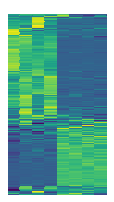

<Figure size 432x288 with 0 Axes>

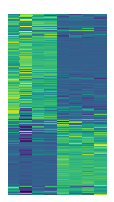

<Figure size 432x288 with 0 Axes>

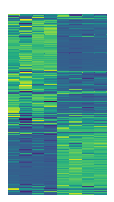

<Figure size 432x288 with 0 Axes>

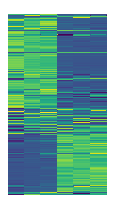

<Figure size 432x288 with 0 Axes>

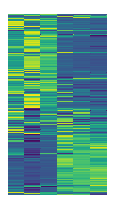

<Figure size 432x288 with 0 Axes>

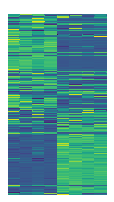

In [98]:
savefig=False

Yp = snapshot_dict['wt'][TEMP]['00']['Yp']
Yf = snapshot_dict['wt'][TEMP]['00']['Yf']
fig = plt.figure()
cm = sns.clustermap(np.hstack((Yp[my_inds],Yf[my_inds])),col_cluster=False,z_score=0,cmap='viridis',
                    dendrogram_ratio=1e-10,linewidths=0.0,figsize=(2.5,3.5))
host_gene_inds = cm.dendrogram_row.reordered_ind
cm.cax.set_visible(False)
cm.ax_heatmap.set_xticks([])
cm.ax_heatmap.set_yticks([])
if savefig: 
    plt.savefig(figDir+'fig1_actual/host00_heatmap.pdf',dpi=300,bbox_inches='tight')
plt.show()


Yp = snapshot_dict['wt'][TEMP]['01']['Yp']
Yf = snapshot_dict['wt'][TEMP]['01']['Yf']
fig = plt.figure()
cm = sns.clustermap(np.hstack((Yp[my_inds][host_gene_inds],Yf[my_inds][host_gene_inds])),col_cluster=False,
                    row_cluster=False,z_score=0,cmap='viridis',dendrogram_ratio=1e-10,linewidths=0.0,figsize=(2.5,3.5))
cm.cax.set_visible(False)
cm.ax_heatmap.set_xticks([])
cm.ax_heatmap.set_yticks([])
if savefig: 
    plt.savefig(figDir+'fig1_actual/host01_heatmap.pdf',dpi=300,bbox_inches='tight')
plt.show()


Yp = snapshot_dict['wt'][TEMP]['10']['Yp']
Yf = snapshot_dict['wt'][TEMP]['10']['Yf']
fig = plt.figure()
cm = sns.clustermap(np.hstack((Yp[my_inds][host_gene_inds],Yf[my_inds][host_gene_inds])),col_cluster=False,
                    row_cluster=False,z_score=0,cmap='viridis',dendrogram_ratio=1e-10,linewidths=0.0,figsize=(2.5,3.5))
cm.cax.set_visible(False)
cm.ax_heatmap.set_xticks([])
cm.ax_heatmap.set_yticks([])
if savefig: 
    plt.savefig(figDir+'fig1_actual/host10_heatmap.pdf',dpi=300,bbox_inches='tight')
plt.show()


Yp = snapshot_dict['icar'][TEMP]['01']['Yp']
Yf = snapshot_dict['icar'][TEMP]['01']['Yf']
fig = plt.figure()
cm = sns.clustermap(np.hstack((Yp[my_inds][host_gene_inds],Yf[my_inds][host_gene_inds])),col_cluster=False,
                    row_cluster=False,z_score=0,cmap='viridis',dendrogram_ratio=1e-10,linewidths=0.0,figsize=(2.5,3.5))
cm.cax.set_visible(False)
cm.ax_heatmap.set_xticks([])
cm.ax_heatmap.set_yticks([])
if savefig: 
    plt.savefig(figDir+'fig1_actual/icar01_heatmap.pdf',dpi=300,bbox_inches='tight')
plt.show()

Yp = snapshot_dict['phlf'][TEMP]['01']['Yp']
Yf = snapshot_dict['phlf'][TEMP]['01']['Yf']
fig = plt.figure()
cm = sns.clustermap(np.hstack((Yp[my_inds][host_gene_inds],Yf[my_inds][host_gene_inds])),col_cluster=False,
                    row_cluster=False,z_score=0,cmap='viridis',dendrogram_ratio=1e-10,linewidths=0.0,figsize=(2.5,3.5))
cm.cax.set_visible(False)
cm.ax_heatmap.set_xticks([])
cm.ax_heatmap.set_yticks([])
if savefig: 
    plt.savefig(figDir+'fig1_actual/phlf10_heatmap.pdf',dpi=300,bbox_inches='tight')
plt.show()

Yp = snapshot_dict['nand'][TEMP]['11']['Yp']
Yf = snapshot_dict['nand'][TEMP]['11']['Yf']
fig = plt.figure()
cm = sns.clustermap(np.hstack((Yp[my_inds][host_gene_inds],Yf[my_inds][host_gene_inds])),col_cluster=False,
                    row_cluster=False,z_score=0,cmap='viridis',dendrogram_ratio=1e-10,linewidths=0.0,figsize=(2.5,3.5))
cm.cax.set_visible(False)
cm.ax_heatmap.set_xticks([])
cm.ax_heatmap.set_yticks([])
if savefig: 
    plt.savefig(figDir+'fig1_actual/nand11_heatmap.pdf',dpi=300,bbox_inches='tight')
plt.show()


#### NAND 1.0 Growth Curves

In [140]:
import scipy.io
growth_curves_dir = '/Users/aqib/Desktop/UCSB/research/BCCL/structured-dmd/NAND_iterate/GrowthCurves/'
od = scipy.io.loadmat(growth_curves_dir+'NAND1_GCs.mat')
od = od['A']
t_od = np.linspace(0,24,len(od))

In [195]:
od[:,[9,21,33,45]].mean(axis=1)

array([0.003  , 0.00275, 0.00325, 0.00425, 0.0045 , 0.0055 , 0.0055 ,
       0.00675, 0.00725, 0.00875, 0.01125, 0.013  , 0.0165 , 0.02025,
       0.02375, 0.02975, 0.037  , 0.04475, 0.05225, 0.0615 , 0.07325,
       0.0875 , 0.10475, 0.1265 , 0.15175, 0.182  , 0.217  , 0.25825,
       0.306  , 0.3635 , 0.41975, 0.479  , 0.54225, 0.60825, 0.66975,
       0.72075, 0.7645 , 0.8045 , 0.84125, 0.8735 , 0.899  , 0.9185 ,
       0.9335 , 0.95   , 0.967  , 0.984  , 1.00125, 1.0175 , 1.03375,
       1.04825, 1.0625 , 1.07425, 1.08525, 1.09525, 1.10425, 1.113  ,
       1.1205 , 1.1275 , 1.1325 , 1.13875, 1.14475, 1.15025, 1.15325,
       1.155  , 1.15575, 1.157  , 1.1565 , 1.1565 , 1.1555 , 1.15425,
       1.1545 , 1.153  , 1.152  , 1.15075, 1.14925, 1.15075, 1.15   ,
       1.14975, 1.1495 , 1.149  , 1.14975, 1.14925, 1.149  , 1.14975,
       1.15025, 1.1505 , 1.15175, 1.15125, 1.15425, 1.15425, 1.15525,
       1.15625, 1.1555 , 1.1575 , 1.15725, 1.15825, 1.1595 , 1.15975,
       1.161  , 1.16

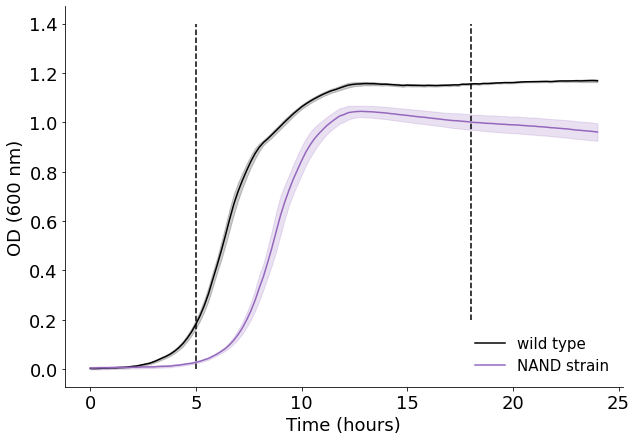

In [242]:
def growth_stats(this_od):
    mean = this_od.mean(axis=1)
    std = this_od.std(axis=1)
    return mean, std
    
plt.figure(figsize=(10,7))
m,s = growth_stats(od[:,[9,21,33,45]]) # wt no induction
plt.plot(t_od,m,c='k',label='wild type')  
plt.fill_between(t_od,m-s,m+s,color='k',alpha=0.2)
# m,s = growth_stats(od[:,[10,22,34,46]]) # wt + arabinose
# plt.plot(t_od,m,c='tab:orange', label='wild type + arabinose')  
# plt.fill_between(t_od,m-s,m+s,color='tab:orange',alpha=0.2)
# m,s = growth_stats(od[:,[57,69,81,93]]) # wt + IPTG
# plt.plot(t_od,m,c='tab:green',label='wild type + IPTG')  
# plt.fill_between(t_od,m-s,m+s,color='tab:green',alpha=0.2)
# m,s = growth_stats(od[:,[48,60,72,84]]) # phlf + arabinose (actually IPTG?)
# plt.plot(t_od,m,c='tab:red',label='PhlF + arabinose')  
# plt.fill_between(t_od,m-s,m+s,color='tab:red',alpha=0.2)
# m,s = growth_stats(od[:,[49,61,73,85]]) # icar + iptg 
# plt.plot(t_od,m,c='tab:blue', label='IcaR + IPTG')  
# plt.fill_between(t_od,m-s,m+s,color='tab:blue',alpha=0.2)
m,s = growth_stats(od[:,[51,63,75,87]]) # nand + ara + iptg 
plt.plot(t_od,m,c='tab:purple',label='NAND strain')  
plt.fill_between(t_od,m-s,m+s,color='tab:purple',alpha=0.2)
plt.vlines(5.0,0.0,1.4,linestyles='dashed',color='k')
plt.vlines(18.0,0.2,1.4,linestyles='dashed',color='k')
plt.legend(frameon=False,ncol=1,fontsize=15,loc='lower right')
plt.xlabel('Time (hours)')
plt.ylabel('OD (600 nm)')
# plt.savefig(figDir + 'fig1_actual/growth_curves.pdf',dpi=300,transparent=True,bbox_inches='tight')
plt.show()
